In [30]:
import pandas as pd
import unicodedata
import re
import numpy as np
import pandas as pd
import emoji
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import datetime
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
import string
import gensim
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim_models

In [31]:
sainsbury_df = pd.read_json('C:/Users/Jimmy/Downloads/sainsburys.json')
sainsbury_df.head()

,created_at,id,id_str,text,display_text_range,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,...,matching_rules,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,extended_tweet,possibly_sensitive,extended_entities,scopes
0,2020-12-02 21:25:42,1334247396054798336,1334247396054798336,RT @felixprojectuk: Today we collected some fo...,None,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,NaN,NaN,...,[{'tag': None}],{'created_at': 'Wed Dec 02 13:30:07 +0000 2020...,NaN,NaN,None,None,None,None,None,NaN
1,2020-03-25 08:55:11,1242736777103839237,1242736777103839237,@ocado @tesco @sainsburys @asda @waitrose @Mor...,None,"<a href=""http://twitter.com/download/iphone"" r...",True,NaN,NaN,2.015550e+07,...,[{'tag': None}],None,NaN,NaN,None,None,{'full_text': '@ocado @tesco @sainsburys @asda...,None,None,NaN
2,2020-03-15 18:07:30,1239251894293409797,1239251894293409797,RT @Danwhite1972: Dear panic buyers\n\nPlease ...,None,"<a href=""http://twitter.com/#!/download/ipad"" ...",False,NaN,NaN,NaN,...,[{'tag': None}],{'created_at': 'Sun Mar 15 08:55:18 +0000 2020...,NaN,NaN,None,None,None,None,None,NaN
3,2020-10-18 10:43:27,1317778311729369088,1317778311729369088,@daisy_haggard @sainsburys Can’t wait to see w...,"[27, 79]","<a href=""http://twitter.com/download/iphone"" r...",False,1.317512e+18,1.317512e+18,2.875019e+09,...,[{'tag': None}],None,NaN,NaN,None,None,None,None,None,NaN
4,2020-11-07 20:52:20,1325179302384717824,1325179302384717824,@lordrix @sainsburys But Sainsbury's have made...,"[21, 140]","<a href=""http://twitter.com/download/android"" ...",True,1.325169e+18,1.325169e+18,5.496380e+07,...,[{'tag': None}],None,NaN,NaN,None,None,"{'full_text': ""@lordrix @sainsburys But Sainsb...",None,None,NaN


In [32]:
sainsbury_df.shape

(82821, 37)

In [33]:
# Checking columns names
sainsbury_df.columns

Index(['created_at', 'id', 'id_str', 'text', 'display_text_range', 'source',
       'truncated', 'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place',
       'contributors', 'is_quote_status', 'quote_count', 'reply_count',
       'retweet_count', 'favorite_count', 'entities', 'favorited', 'retweeted',
       'filter_level', 'lang', 'matching_rules', 'retweeted_status',
       'quoted_status_id', 'quoted_status_id_str', 'quoted_status',
       'quoted_status_permalink', 'extended_tweet', 'possibly_sensitive',
       'extended_entities', 'scopes'],
      dtype='object')

In [34]:
# Selecting certain columns
sainsbury_df = sainsbury_df[['created_at','text','quote_count','reply_count','retweet_count','favorite_count','extended_tweet']]
# Removing rows with null value
sainsbury_df = sainsbury_df.dropna()

In [35]:
# Extracting full_text from entended_tweet
sainsbury_df['full_text'] = [x['full_text'] if isinstance(x, dict) and 'full_text' in x else None for x in sainsbury_df['extended_tweet']]
# Combinning the data from text to further update full_text
sainsbury_df['full_text'] = [y if x==None else x for x,y in zip(sainsbury_df['full_text'],sainsbury_df['text'])]
sainsbury_df.head(50)

,created_at,text,quote_count,reply_count,retweet_count,favorite_count,extended_tweet,full_text
1,2020-03-25 08:55:11,@ocado @tesco @sainsburys @asda @waitrose @Mor...,0,0,0,1,{'full_text': '@ocado @tesco @sainsburys @asda...,@ocado @tesco @sainsburys @asda @waitrose @Mor...
4,2020-11-07 20:52:20,@lordrix @sainsburys But Sainsbury's have made...,0,0,0,0,"{'full_text': ""@lordrix @sainsburys But Sainsb...",@lordrix @sainsburys But Sainsbury's have made...
8,2020-03-18 18:23:42,@jojobowley @asda @sainsburys @Tesco @Morrison...,0,1,0,0,{'full_text': '@jojobowley @asda @sainsburys @...,@jojobowley @asda @sainsburys @Tesco @Morrison...
9,2020-03-23 11:10:40,@sachnusun @sainsburys This is the SAME number...,0,0,0,0,{'full_text': '@sachnusun @sainsburys This is ...,@sachnusun @sainsburys This is the SAME number...
11,2020-03-09 22:35:06,#Shoutout to @sainsburys at MonksX for the lov...,0,1,0,0,{'full_text': '#Shoutout to @sainsburys at Mon...,#Shoutout to @sainsburys at MonksX for the lov...
16,2020-03-21 08:46:30,I’m diabetic &amp; went to @sainsburys during ...,0,0,0,7,{'full_text': 'I’m diabetic &amp; went to @sai...,I’m diabetic &amp; went to @sainsburys during ...
17,2020-04-10 19:18:36,Massive shout out to the awesome #VeganJunkies...,0,0,7,11,{'full_text': 'Massive shout out to the awesom...,Massive shout out to the awesome #VeganJunkies...
20,2020-03-15 14:56:12,"@JYTL888 @sainsburys @Morrisons Hi, As a resul...",0,0,0,2,"{'full_text': ""@JYTL888 @sainsburys @Morrisons...","@JYTL888 @sainsburys @Morrisons Hi, As a resul..."
25,2020-12-19 20:59:59,@mr_plantgeek @sainsburys That happened to me....,0,0,0,6,{'full_text': '@mr_plantgeek @sainsburys That ...,@mr_plantgeek @sainsburys That happened to me....
26,2020-03-24 10:13:00,Serious question... family of four having to i...,0,1,0,1,{'full_text': 'Serious question... family of f...,Serious question... family of four having to i...


In [36]:
#Coverting time format
sainsbury_df['created_at'] = pd.to_datetime(sainsbury_df['created_at'])
# Setting the time scope
start_d = '2020-7-01'
end_d = '2020-12-31'
# Extracting the data within the scope
filtered_df = sainsbury_df[(sainsbury_df['created_at'] >= start_d) & (sainsbury_df['created_at'] <= end_d)]

In [37]:
# Removing URL
def remove_URL(df):
    return re.sub(r'https?://\S+|www\.\S+',' ', df)
filtered_df['full_text'] = filtered_df['full_text'].apply(remove_URL)

# Removing punctuations
def remove_punctuations(df):
    return re.sub(r'[^\w\s]'," ", df)
filtered_df['full_text'] = filtered_df['full_text'].apply(remove_punctuations)

# Removing numbers
def remove_numbers(df):
    return re.sub(r"[0-9]","", df)
filtered_df['full_text'] = filtered_df['full_text'].apply(remove_numbers)

# Removing mentions
def remove_mentions(df):
    return re.sub(r"@\S+","", df)
filtered_df['full_text'] = filtered_df['full_text'].apply(remove_mentions)

# Removing hashtags
def remove_hashtags(df):
    return re.sub(r"#\S+","", df)
filtered_df['full_text'] = filtered_df['full_text'].apply(remove_hashtags)

# Converting emojis to text
def convert_emojis(text):
    return emoji.demojize(text)
filtered_df['full_text'] = filtered_df['full_text'].apply(convert_emojis)

# Converting original texts to lowercase texts
def lowercase(df):
    return df.lower()
filtered_df['full_text'] = filtered_df['full_text'].apply(lowercase)

C:\Users\Jimmy\AppData\Local\Temp\ipykernel_2572\2084681134.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['full_text'] = filtered_df['full_text'].apply(remove_URL)
C:\Users\Jimmy\AppData\Local\Temp\ipykernel_2572\2084681134.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['full_text'] = filtered_df['full_text'].apply(remove_punctuations)
C:\Users\Jimmy\AppData\Local\Temp\ipykernel_2572\2084681134.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [38]:
filtered_df['full_text'].head()

4      lordrix  sainsburys but sainsbury s have made...
25     mr_plantgeek  sainsburys that happened to me ...
32     mrdanwalker  amazonuk  sainsburys  asda i tri...
33     sainsburys and will you have posters and anno...
35     sainsburys reported an item missing from my d...
Name: full_text, dtype: object

In [39]:
# Creating stop words list
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
# Setting some additional stop words
additional_words = {'https', 'asda', 'tesco','morrisons','lidlgb','aldiuk','waitrose','morrison','sainsbury','sainsburys','coopuk','signed','open','letter','asking','join','amp','marksandspencer','ocado','icelandfoods'}
stop_words.update(additional_words)

# Defining a function to return the text after removal of stop words
def cleaning_stopwords(text):
    cleaned_words = [word.strip() for word in text.split() if word.lower() not in stop_words]
    cleaned_text = ' '.join(cleaned_words)
    return cleaned_text

# Applying the function to the column named 'full_text'
filtered_df['full_text'] = filtered_df['full_text'].apply(cleaning_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jimmy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\Jimmy\AppData\Local\Temp\ipykernel_2572\1540692840.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['full_text'] = filtered_df['full_text'].apply(cleaning_stopwords)


In [40]:
filtered_df.shape

(14872, 8)

In [41]:
filtered_df['full_text'].head()

4                    lordrix made big thing website hel
25    mr_plantgeek happened ordered piece got sent k...
32    mrdanwalker amazonuk tried taking life two mon...
33    posters announcements shop lifting smoking etc...
35    reported item missing delivery morning via con...
Name: full_text, dtype: object

In [42]:
filtered_df1 = filtered_df.copy()
filtered_df1.head()

,created_at,text,quote_count,reply_count,retweet_count,favorite_count,extended_tweet,full_text
4,2020-11-07 20:52:20,@lordrix @sainsburys But Sainsbury's have made...,0,0,0,0,"{'full_text': ""@lordrix @sainsburys But Sainsb...",lordrix made big thing website hel
25,2020-12-19 20:59:59,@mr_plantgeek @sainsburys That happened to me....,0,0,0,6,{'full_text': '@mr_plantgeek @sainsburys That ...,mr_plantgeek happened ordered piece got sent k...
32,2020-11-12 19:52:28,@mrdanwalker @AmazonUK @sainsburys @asda I tri...,0,0,0,0,{'full_text': '@mrdanwalker @AmazonUK @sainsbu...,mrdanwalker amazonuk tried taking life two mon...
33,2020-07-24 16:07:45,@sainsburys And will you have posters and anno...,0,1,0,0,{'full_text': '@sainsburys And will you have p...,posters announcements shop lifting smoking etc...
35,2020-12-30 10:23:08,@sainsburys Reported an item missing from my d...,0,0,0,0,{'full_text': '@sainsburys Reported an item mi...,reported item missing delivery morning via con...


In [43]:
# Initializing the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Creating a function to lemmatize the text
def lemmatize_on_text(text):
    return lemmatizer.lemmatize(text)

# Applying the function to the cloumn named 'full_text'
filtered_df1['full_text'] = filtered_df1['full_text'].apply(lemmatize_on_text)

In [44]:
filtered_df1['full_text'].head()

4                    lordrix made big thing website hel
25    mr_plantgeek happened ordered piece got sent k...
32    mrdanwalker amazonuk tried taking life two mon...
33    posters announcements shop lifting smoking etc...
35    reported item missing delivery morning via con...
Name: full_text, dtype: object

Text(0.5, 1.0, 'Tweets Trend in the Half Year')

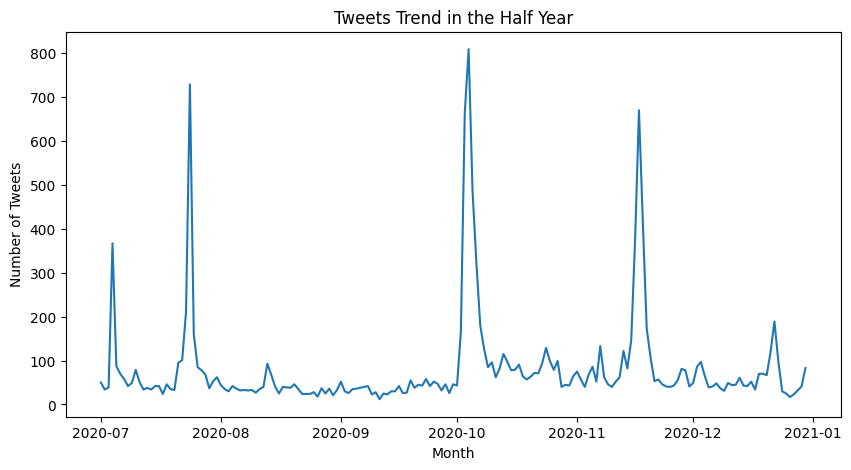

In [45]:
# Creating a column only showing the year, month, and date of those tweets
filtered_df1['date_only'] = filtered_df1['created_at'].dt.date

# Drawing a line plot to show the change of number of tweets related to sainsburys in the half year
plt.figure(figsize=[10,5])
plt.plot(filtered_df1.groupby(by=['date_only'])['text'].count()) # Categorized by date to show the number of tweets on each date
# Setting the labels and title
plt.ylabel('Number of Tweets') 
plt.xlabel('Month')  
plt.title('Tweets Trend in the Half Year') 

([<matplotlib.axis.XTick at 0x179afee5710>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23')])

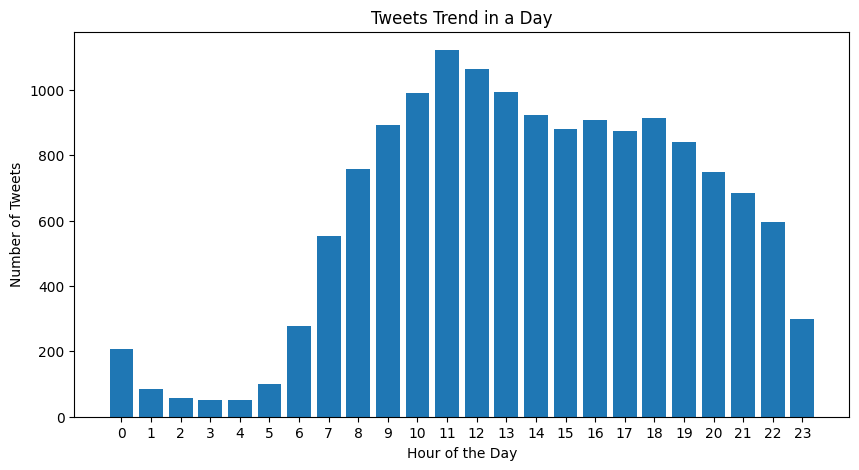

In [46]:
# Creating a column only showing the releasing hour of those tweets in one day
filtered_df1['hour'] = filtered_df1['created_at'].dt.hour
hourly_counts = filtered_df1.groupby('hour')['text'].count()

# Drawing a barplot show the change of number of tweets related to sainsburys in a day
plt.figure(figsize=[10,5])
plt.bar(hourly_counts.index, hourly_counts.values)  
# Setting the labels and title
plt.xlabel('Hour of the Day')  
plt.ylabel('Number of Tweets')  
plt.title('Tweets Trend in a Day') 
plt.xticks(range(0, 24))  

In [47]:
# Importing the sentiment analysis tool
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
# Initializing sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Defining a fuction to get the compound sentiment score
def get_compound_score(text):
    sentiment_score = sia.polarity_scores(text)
    return sentiment_score['compound']

# Storing the compound scores in the new column named 'sentiment_score'
filtered_df1['sentiment_score'] = filtered_df1['full_text'].apply(get_compound_score)

# Categoring the tweets into three types of sentiment: positive, negative or neutral
def sentiment_define(df):
    if df > 0.05:
        return 'Positive'
    elif df < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Storing the sentiment status in the new column named 'sentiment'    
filtered_df1['sentiment'] = filtered_df1['sentiment_score'].apply(sentiment_define)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Jimmy\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


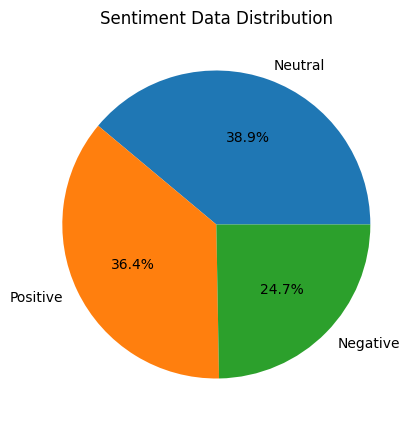

In [48]:
# Counting the number of comments with different sentiment status
val_count = filtered_df1['sentiment'].value_counts()

# Drawing a pie plot
plt.figure(figsize=(5,5)) 
plt.pie(val_count, labels=val_count.index, autopct='%1.1f%%')
plt.title('Sentiment Data Distribution')  
plt.show()  

C:\Users\Jimmy\AppData\Local\Temp\ipykernel_2572\2069658280.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=filtered_df1, x='sentiment_score', shade=True, color='g')


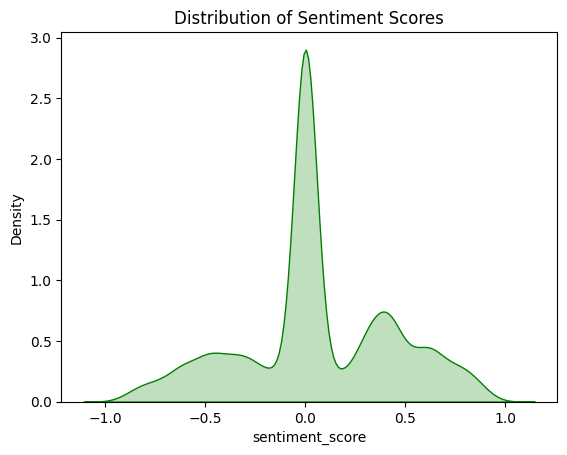

In [49]:
# Drawing a Kernel density plot
sns.kdeplot(data=filtered_df1, x='sentiment_score', shade=True, color='g')
plt.title("Distribution of Sentiment Scores")
plt.show()

C:\Users\Jimmy\AppData\Local\Temp\ipykernel_2572\1684573248.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(negative_scores, color='red',shade=True)
C:\Users\Jimmy\AppData\Local\Temp\ipykernel_2572\1684573248.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(positive_scores, color='blue',shade=True)


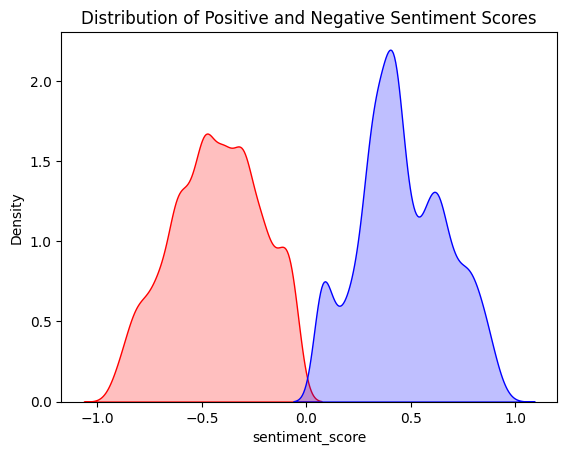

In [50]:
# Extracting the sentiment scores for each comment with negative sentimnet
negative_scores = filtered_df1[filtered_df1.sentiment == "Negative"]['sentiment_score']
# Extracting the sentiment scores for each comment with positve sentimnet
positive_scores = filtered_df1[filtered_df1.sentiment == "Positive"]['sentiment_score']

# Drawing a Kernel density plot
sns.kdeplot(negative_scores, color='red',shade=True)
sns.kdeplot(positive_scores, color='blue',shade=True)
plt.title("Distribution of Positive and Negative Sentiment Scores")
plt.show()

C:\Users\Jimmy\AppData\Roaming\Python\Python311\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


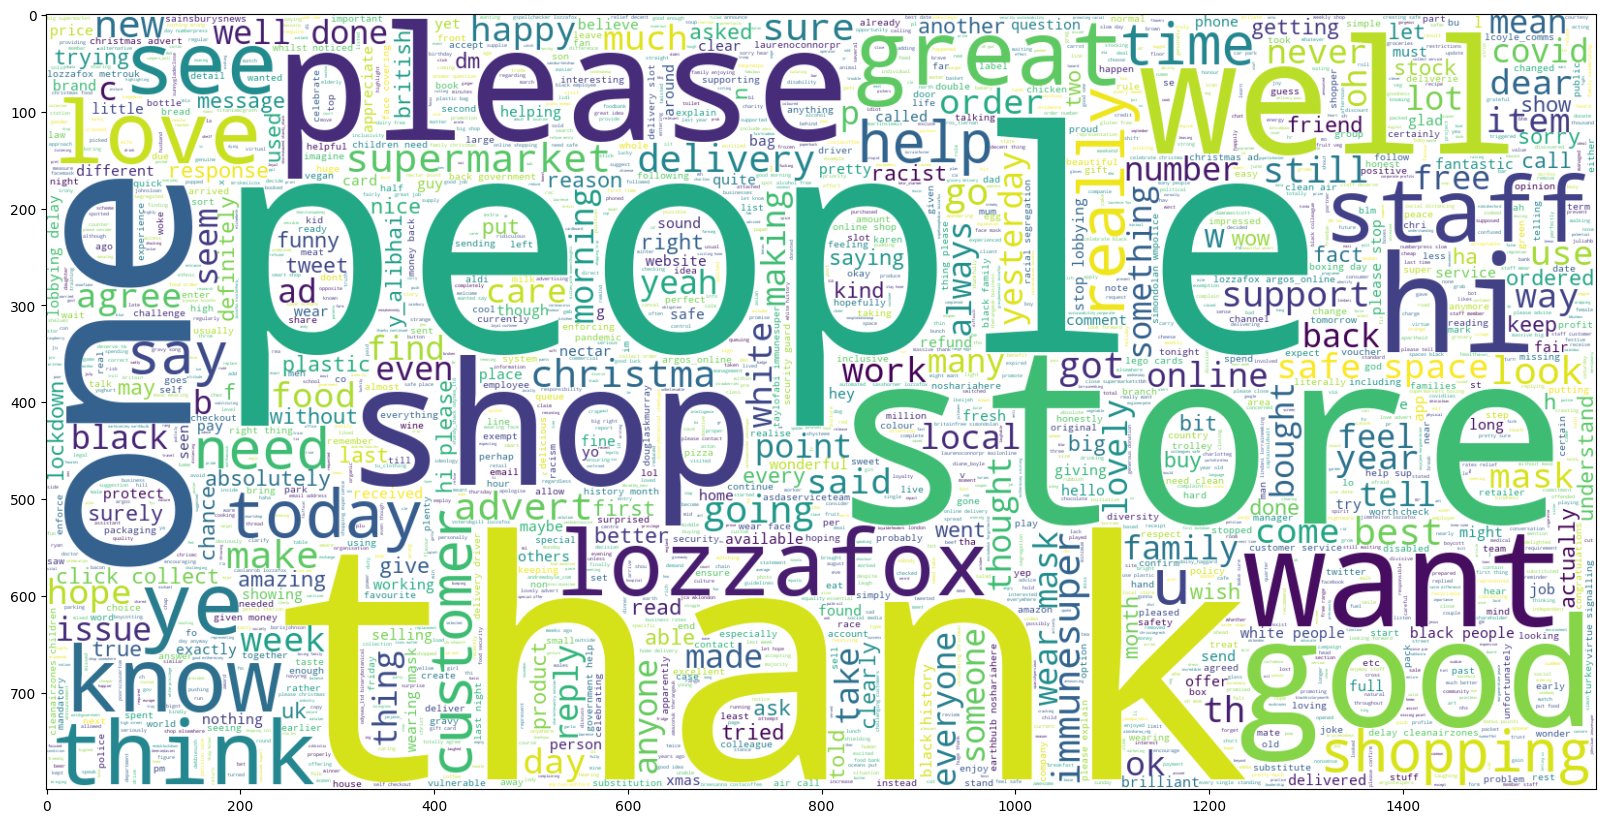

In [51]:
# Drawing a word cloud plot for positive comments
plt.figure(figsize = (20,20)) 
wc = WordCloud(background_color = 'white',max_words = 2000 , width = 1600 , height = 800).generate(" ".join(filtered_df1[filtered_df1.sentiment == 'Positive'].full_text))
plt.imshow(wc , interpolation = 'bilinear')

C:\Users\Jimmy\AppData\Roaming\Python\Python311\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


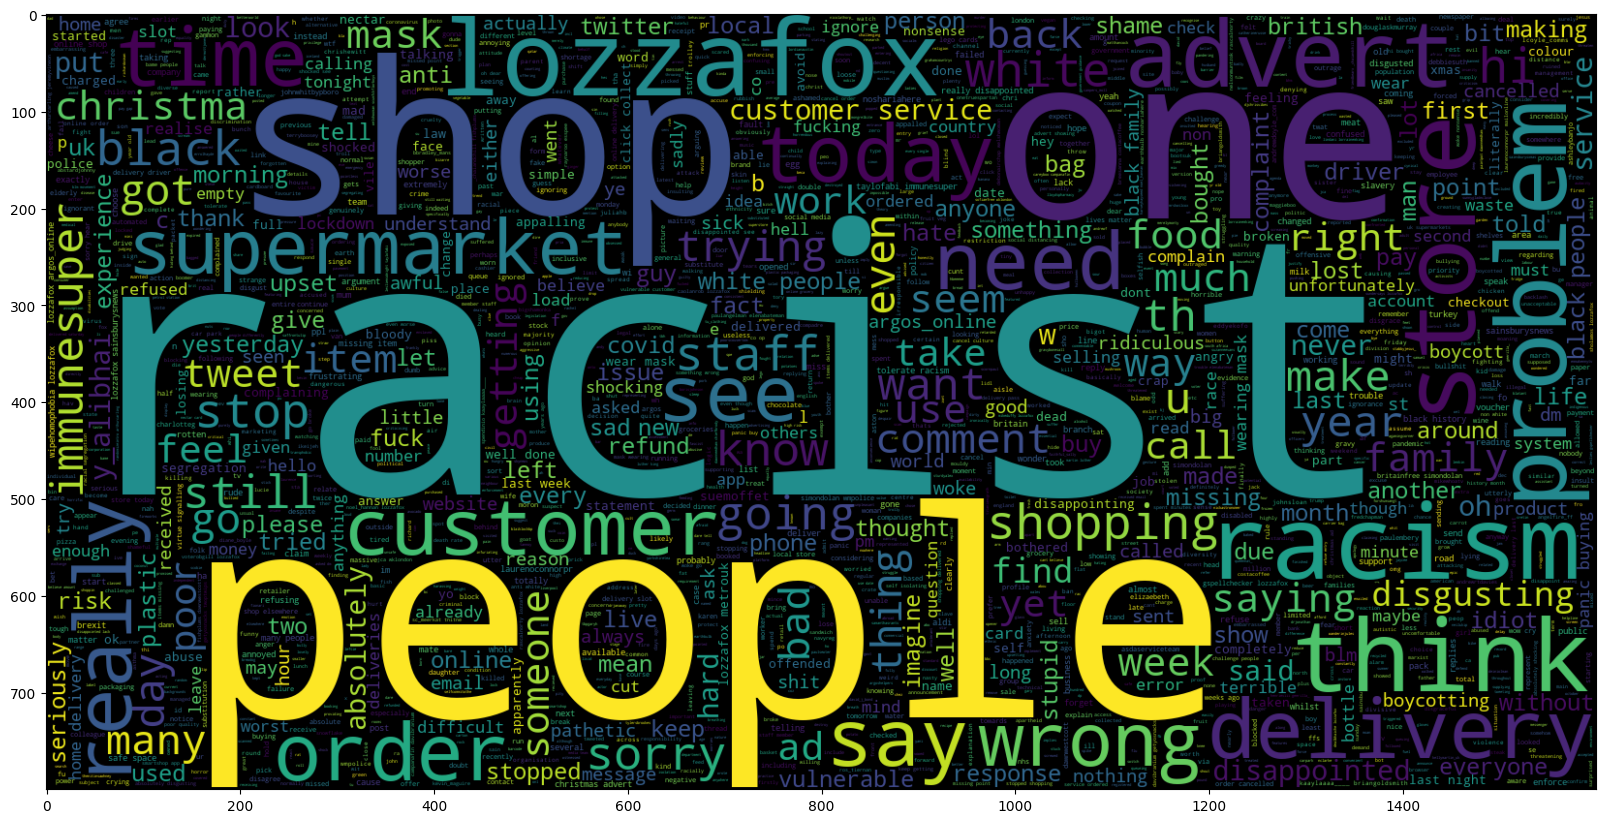

In [52]:
# Drawing a word cloud plot for negative comments
plt.figure(figsize = (20,20)) 
wc = WordCloud(background_color = 'black',max_words = 2000 , width = 1600 , height = 800).generate(" ".join(filtered_df1[filtered_df1.sentiment == 'Negative'].full_text))
plt.imshow(wc , interpolation = 'bilinear')

In [53]:
# Defining a funciton to get the tokenized text
def generate_tokens(tweet):
    words=[]
    for word in tweet.split(' '):
    # using the if condition because there mgith be some spaces
        if word!='':
           words.append(word)
    return words

# Storing the generated tokens in a new column named 'tokens'
filtered_df1['tokens']=filtered_df1.full_text.apply(generate_tokens)
filtered_df1['tokens'].head()

4             [lordrix, made, big, thing, website, hel]
25    [mr_plantgeek, happened, ordered, piece, got, ...
32    [mrdanwalker, amazonuk, tried, taking, life, t...
33    [posters, announcements, shop, lifting, smokin...
35    [reported, item, missing, delivery, morning, v...
Name: tokens, dtype: object

In [54]:
# Defining a function to convert list object to dictionary object
def create_dictionary(words):
    return corpora.Dictionary(words)

# Creating an object to contain the tokenized text with dictionary format
id2word=create_dictionary(filtered_df1['tokens'])
print(id2word)

Dictionary<21861 unique tokens: ['big', 'hel', 'lordrix', 'made', 'thing']...>


In [55]:
filtered_df1.to_csv('clean_sainsburys_dataset.csv')

In [56]:
# Defing a funcition to create a corpus from a list of tokens
def create_document_matrix(tokens,id2word):
    corpus = []
    for text in tokens:
        corpus.append(id2word.doc2bow(text))
    return corpus

# Passing the dataframe column having tokens and dictionary
corpus=create_document_matrix(filtered_df1['tokens'],id2word)

In [57]:
# Initializing a LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=8, random_state=100, )

In [58]:
# Visualizing the LDA model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.285198  0.067563       1        1  17.660292
0      0.146940  0.203475       2        1  13.782500
6      0.288214 -0.041830       3        1  13.228271
5      0.104297  0.003183       4        1  12.468670
1     -0.172848 -0.200616       5        1  11.699963
4     -0.067635  0.237249       6        1  11.356741
2      0.084209 -0.249079       7        1  10.784153
3     -0.097979 -0.019945       8        1   9.019410, topic_info=             Term         Freq        Total Category  logprob  loglift
69       lozzafox   701.000000   701.000000  Default  30.0000  30.0000
37       delivery   574.000000   574.000000  Default  29.0000  29.0000
306        people  1117.000000  1117.000000  Default  28.0000  28.0000
190   immunesuper   381.000000   381.000000  Default  27.0000  27.0000
168        family   246.000000   246.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
424        trying    43.013275   210.203333   Topic8  -5.5721   0.8192
1020        order    45.791326   379.637899   Topic8  -5.5096   0.2907
2204   understand    35.456002    87.165893   Topic8  -5.7654   1.5063
974            oh    34.115183   156.613938   Topic8  -5.8039   0.8818
62          phone    33.140285    79.157082   Topic8  -5.8329   1.5351

[569 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
67        1  0.157032  absolutely
67        2  0.455392  absolutely
67        3  0.047110  absolutely
67        5  0.180587  absolutely
67        6  0.070664  absolutely
...     ...       ...         ...
932       1  0.016274          yo
932       2  0.797405          yo
932       5  0.032547          yo
932       7  0.146462          yo
576       2  0.981934       young

[1437 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 1, 7, 6, 2, 5, 3, 4])